# Setup
Standard imports.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

`get_images` is used later for retrieving a list of images. I couldn't figure out how to load all of the sequences so maybe this could be replaced by someone else's code. `cv2.IMREAD_UNCHANGED` cos cv2 likes to screw up the 16-bit images.

In [2]:
def get_images():
    # Change later to load in all sequences/images
    return [cv2.imread(f'../Sequences/01/t00{i}.tif', cv2.IMREAD_UNCHANGED) for i in range(5)]

# Preprocessing
My overall goal is to make the cells white and everything else black, so it can be masked later, and used for edge detection and segmentation techniques.

## Contrast stretching
The input images are really squished up in terms of contrast, mostly grey and quite hard to spot cells. `cv2.normalize` with the `NORM_MINMAX` setting is basically contrast stretching to any min and max - in this case 0 and `65535` (the highest pixel value in 16 bit images)

In [3]:
def contrast_stretch(img):
    stretched = cv2.normalize(img, None, 0, 65535, cv2.NORM_MINMAX, cv2.CV_16U)
    return stretched

See the example below:

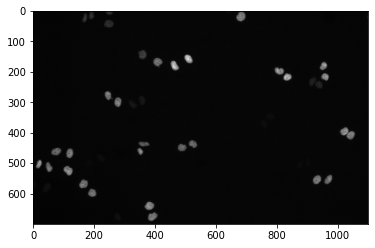

In [4]:
img = get_images()[0]
img_stretched = contrast_stretch(img)
plt.imshow(img_stretched, cmap='gray')
plt.show()

## Thresholding
For a bunch of processes I need an image with only white and black pixels, no in between. `cv2.threshold` on the `THRESH_BINARY` mode basically sets everything below the first number to black, and everything above it to white. I played around with the first number and `65535//16` seems to work? There are definitely better ways to do this part.

In [5]:
def binary_threshold(img):
    # First return value is something else, not sure why, don't need it
    _, thresh = cv2.threshold(img, 65535//16, 65535, cv2.THRESH_BINARY)
    return thresh

Example:

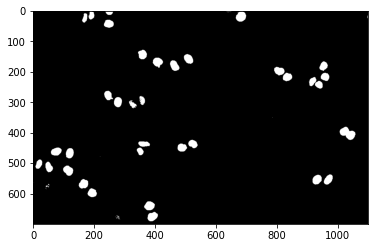

In [6]:
img = get_images()[0]
img_stretched = contrast_stretch(img)
img_thresh = binary_threshold(img_stretched)
plt.imshow(img_thresh, cmap='gray')
plt.show()

## Noise removal
There might be some noise, things in the image that aren't the background colour (black) but aren't actually cells. `cv2.erode` shrinks every group of white pixels, hopefully enough that small clusters of noise get wiped out. `cv2.dilate` grows every group of white pixels, hopefully so the cells are their original size again. `5` seems to be fine for kernel size but I think we should aim to have the kernel as big as possible without wiping out the cells themselves? Should test more images but I didn't get a chance to.

In [7]:
def remove_noise(img):
    
    # 5 seems good enough
    kernel = np.ones((5,5),np.uint16)
    
    # I didn't try multiple iterations, maybe would help for noisier images
    erosion = cv2.erode(img, kernel, iterations=1)
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    return dilation

Example:

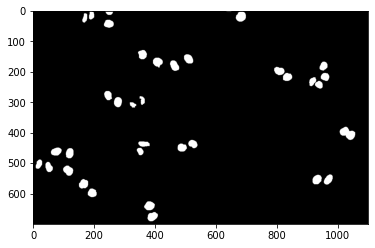

In [8]:
img = get_images()[0]
img_stretched = contrast_stretch(img)
img_thresh = binary_threshold(img_stretched)
img_bg_removed = remove_noise(img_thresh)
plt.imshow(img_bg_removed, cmap='gray')
plt.show()

# Segmentation
Need to get some sorta data structure that says which cells are where. I think this is really hard actually lol

## Edge detection
Sobel kinda sucks for lines that aren't straight, so there's a bunch of wonky edges that are missing or faded in the output, but it wasn't so hard to get this working, like some other methods were. I tried `ksize` at `5`, `3`, and `1`, and didn't get great outlines with any tbh.

In [9]:
def get_edges(img):
    # Sobel output is a float instead of int
    img_sobelxy = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=1)
    
    # Converting float to int, also normalising so black is pixel value 0
    img_sobelxy_normal = cv2.normalize(img_sobelxy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_16U)
    
    # Thresholding so that edges are white and everything else is black
    _, img_sobelxy_thresh = cv2.threshold(img_sobelxy_normal, 1, 255, cv2.THRESH_BINARY)
    return img_sobelxy_thresh

Example:

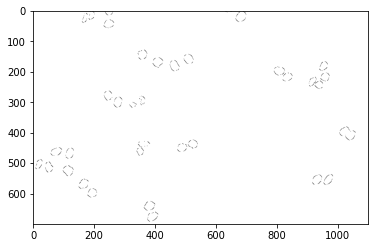

In [10]:
img = get_images()[0]
img_stretched = contrast_stretch(img)
img_thresh = binary_threshold(img_stretched)
img_bg_removed = remove_noise(img_thresh)
img_edges = get_edges(img_bg_removed)
plt.imshow(img_edges, cmap='gray')
plt.show()

## Contours
Don't really get this tbh. As far as I can tell, contours is ever harder to implement than edges. Seems okay so far. Played around with the settings, don't fully know what they do but it's an acceptable output imo.

In [11]:
def get_contours(img):
    # findContours doesn't like 16 bit, need to convert
    img_8b = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    # First return value is something weird, not sure but probs don't need it
    _, contours, hierarchy = cv2.findContours(img_8b, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours, hierarchy

Also have to draw the contours

In [12]:
from random import randint, shuffle

# Returns random pastel-y colour. Looks pretty, don't judge.
def get_random_colour_8b():
    return [randint(100,256) for _ in range(3)]

def draw_contours(img, contours, hierarchy):
    # drawContours doesn't like 16 bit, need to convert. Using normalize will contrast stretch the image.
    img_8b = (img/256).astype('uint8')
    
    # Old code that was stretching the contrast on the image during conversion.
    # img_8b = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    # drawContours needs to draw in colours, need to convert
    img_overlay = cv2.cvtColor(img_8b, cv2.COLOR_GRAY2BGR)
    
    # Index needed so drawContours knows which one to draw
    # Now that I think about it contour is not needed lol
    for index, contour in enumerate(contours):
        
        # Would probably want to keep colour of a specific cell the same across multiple frames
        # That seems really hard though
        colour = get_random_colour_8b()
        
        # magic
        cv2.drawContours(img_overlay, contours, index, colour, 5, cv2.LINE_AA, hierarchy, 0)
        
    return img_overlay

Example:

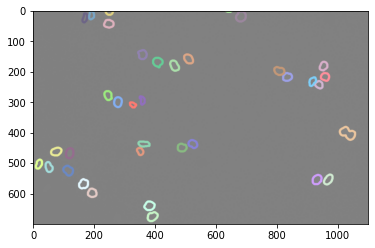

In [13]:
img = get_images()[0]
img_stretched = contrast_stretch(img)
img_thresh = binary_threshold(img_stretched)
img_bg_removed = remove_noise(img_thresh)
img_contours, img_hierarchy = get_contours(img_bg_removed)
img_contours_drawn = draw_contours(img, img_contours, img_hierarchy)
plt.imshow(img_contours_drawn)
plt.show()

# Interactivity
I think I did this right. Probably. The first part is using `cv2.imshow` instead of `plt.imshow`, so that we get a new window and can check what keys are pressed or where the mouse is clicked. I set it up so `a` goes backwards 1 frame and `d` goes forwards 1 frame. `q` closes the window.

In [14]:
# This makes the imshow open in a new window, so clicking works and stuff

def interactive_window(img_display_list, img_mask_list):

    current_frame = 0
    
    def onclick(event, x, y, flags, param):
        # Only want click events
        if not event == cv2.EVENT_LBUTTONDOWN:
            return
        
        # Check if it's a cell according to the mask
        if img_mask_list[current_frame][y][x]:
            print('cell clicked')
            # In the future, would have to do something here to figure out which cell it is
            # (after we know what segmentation method we're using and how the cells are described)
            # After that, instead of printing cell clicked, we can print the centroid for that specific cell

    cv2.namedWindow('Cells')
    cv2.setMouseCallback('Cells', onclick)
    cv2.imshow('Cells', img_display_list[current_frame])
            
    while True:
        key = cv2.waitKey(0)
        if key == ord('a'):
            current_frame -= 1
            current_frame %= len(img_display_list)
            cv2.imshow('Cells', img_display_list[current_frame])
        if key == ord('d'):
            current_frame += 1
            current_frame %= len(img_display_list)
            cv2.imshow('Cells', img_display_list[current_frame])
        if key == ord('q'):
            break
    
    cv2.destroyAllWindows()

Example of loading and processing a sequence of images

In [15]:
def get_and_process_images():
    img_original_list = get_images()
    img_stretched_list = [contrast_stretch(img) for img in img_original_list]
    img_thresh_list = [binary_threshold(img) for img in img_stretched_list]
    img_noiseless_list = [remove_noise(img) for img in img_thresh_list]
    img_contours_and_hierarchy_list = [(original, *get_contours(img)) for img, original in zip(img_noiseless_list, img_original_list)]
    img_contours_drawn_list = [draw_contours(img, contours, hierarchy) for img, contours, hierarchy in img_contours_and_hierarchy_list]
    
    img_mask_list = img_noiseless_list
    img_display_list = img_contours_drawn_list
    
    return img_display_list, img_mask_list

Run the cell below to get a new window that can be clicked on and navigated. If you close the window instead of pressing `q` then it gets weird.

In [21]:
img_display_list, img_mask_list = get_and_process_images()
interactive_window(img_display_list, img_mask_list)

# Cell splitting

In [33]:
def get_eccentricity(width, height):
    return max(width,height)/min(width,height)

In [34]:
# Receives a thresholded image and gets bounding boxes for each contour
def get_bounding_box_list(img):
    # Just my get contours function for now - will replace with someone's working get contours function later
    contours, heirarchy = get_contours(img)
        
    rect_list = {}
    
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        rect_list[rect[0]] = get_eccentricity(rect[1][0], rect[1][1])
        
    return rect_list

In [35]:
# Extracts the y,x coordinates of the bounding boxes into a new list where the eccentricity is greater than the limit 
# (more oblongular so undergoing mitosis)
def extract_cells_splitting(rect_list, limit):
    cells_splitting = {}
    for coord in rect_list:
        if (rect_list[coord] > limit):
            cells_splitting[round(coord[1]), round(coord[0])] = rect_list[coord]
    
    return cells_splitting
    

In [36]:
# Finds the associated cell of the y,x coordinate of the bounding box through a dict where each key is a pixel 
# coordinate, and each value is the cell that the pixel belongs to.
def map_list_to_cells(cells_splitting_list, cells_by_coord):
    all_cells = set(cells_by_coord)
    coord_points = set(cells_splitting_list)
    cells_in_mitosis = []
    
    for coord in coord_points:
        for cell_coords in all_cells:
            if(coord == cell_coords):
                cells_in_mitosis.append(cells_by_coord[cell_coords])
                
#     for coord in all_cells.intersection(cells_in_mitosis):
#         cells_in_mitosis.append(cells_by_coord[coord])
        
    return cells_in_mitosis

In [39]:
# Receives thresholded image, the limit and a dict of cells i.e. {(coordinates): cells}
def detect_mitosis(img, limit, cells_by_coord):
    box_list = get_bounding_box_list(img)
    cells_splitting = extract_cells_splitting(box_list, limit)
    return map_list_to_cells(cells_splitting, cells_by_coord)
        

In [40]:
all_cells = { (5,200): 1, (8,250): 1, (554, 970): 2, (555, 1000): 2, (58, 900): 3}
detect_mitosis(img_bg_removed, 1.5, all_cells)

[2, 1]
